In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm

import scipy, scipy.stats

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import grangercausalitytests
import math

https://barnesanalytics.com/analyzing-multivariate-time-series-using-arimax-in-python-with-statsmodels

In [2]:
df=pd.read_csv('/home/madhav/Documents/YouTube/Germany_data.csv')


In [3]:
df.head(5)

,Date,Revenue,Holidays
0,04/2015,44593.861136,2
1,05/2015,53937.649610,4
2,06/2015,62453.156104,2
3,07/2015,46229.681728,0
4,08/2015,48286.857112,1


len(df) # Jerquie Bera test of normality works only for data having rows more than 2000

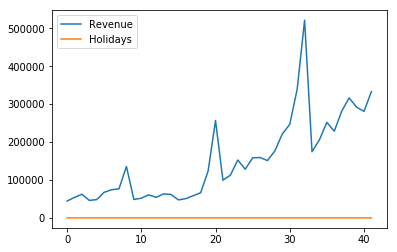

In [4]:
df[['Revenue','Holidays']].plot()
plt.show()

# Function for Ad Fuller Graph and Test  

In [5]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    plt.figure(figsize=(12,8))
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:# This is visual technioque.
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    #print('Res#ts_log_diff = ts_log - 2*ts_log.shift()+ ts_log.shift(periods=2) # Double Differencingults of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')# AIC gives us what we want in Time series i.e exact value and actual value
    # 
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# Initial Test of Stationarity of Revenue

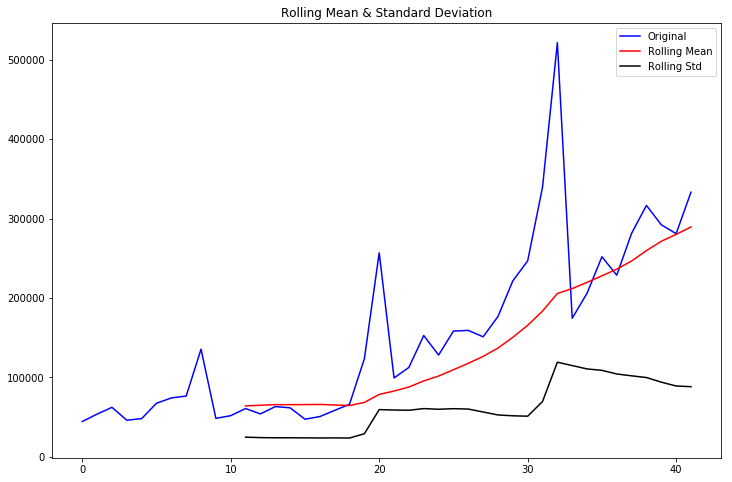

Test Statistic                 -2.138041
p-value                         0.229496
#Lags Used                      0.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64


In [6]:
df.dropna(inplace=True)
test_stationarity(df['Revenue'])

# Initial Test of Stationarity of Holidays

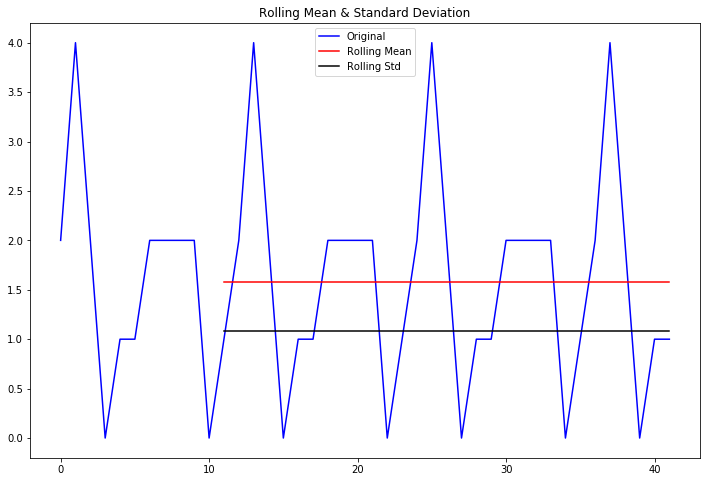

Test Statistic                -8.143646e+13
p-value                        0.000000e+00
#Lags Used                     1.000000e+01
Number of Observations Used    3.100000e+01
Critical Value (1%)           -3.661429e+00
Critical Value (5%)           -2.960525e+00
Critical Value (10%)          -2.619319e+00
dtype: float64


In [7]:
df.dropna(inplace=True)
test_stationarity(df['Holidays'])

In [8]:
df['const']=1
model1 = sm.OLS(endog=df['Revenue'],exog=df[['Holidays','const']])
results1=model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                   0.05475
Date:                Thu, 21 Feb 2019   Prob (F-statistic):              0.816
Time:                        20:22:57   Log-Likelihood:                -546.63
No. Observations:                  42   AIC:                             1097.
Df Residuals:                      40   BIC:                             1101.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Holidays    3755.9565   1.61e+04      0.234      0.8

# Degree of Freedom of the model and Residuals

The degrees of freedom of the model are the number of predictor, or explanatory variables. The degrees of freedom 
of the residuals is the number of observations minus the degrees of freedom of the model, minus one.

http://connor-johnson.com/2014/02/18/linear-regression-with-python/

# Omnibus

In [9]:
p = 1.0 - scipy.stats.chi2(2).cdf(2.058)
print('Pr( Omnibus ) = {}'.format(p))

Pr( Omnibus ) = 0.35736414609271283


The Omnibus test uses skewness and kurtosis to test the null hypothesis that a distribution is normal. 
In this case, we’re looking at the distribution of the residual. If we obtain a very small value 
for \Pr( \mbox{ Omnibus } ), then the residuals are not normally distributed about zero, and we should maybe 
look at our model more closely. 

# Durbin Watson Test

The Durbin-Watson test checks for autocorrelation by looking at he residuals separated by some lag; here 
the lag is one.

The Durbin-Watson statistic is approximately equal to 2(1-r) where r is the sample autocorrelation.

The statistic ranges from zero to four, and a value around two suggests that there is no autocorrelation. Values greater than two suggest negative correlation, and values less that one suggest positive correlation.



# Jarque-Bera test

The Jarque-Bera test is another test that considers skewness (S), and kurtosis (K). The null hypothesis is that
the distribution is normal, that both the skewness and excess kurtosis equal zero, or alternatively, that the 
skewness is zero and the regular run-of-the-mill kurtosis is three. Unfortunately, with small samples the
Jarque-Bera test is prone rejecting the null hypothesis–that the distribution is normal–when it is in fact true.

In [10]:
p = 1.0 - scipy.stats.chi2(2).cdf(1.388)
print('JB-statistic: {:.5f},  p-value: {:.5f}'.format(1.388, p ))

JB-statistic: 1.38800,  p-value: 0.49957


# Condition Number

The condition number measures the sensitivity of a function’s output to its input. 
When two predictor variables are highly correlated, which is called multicolinearity, the coefficients or 
factors of those predictor variables can fluctuate erratically for small changes in the data, or the model. 
Ideally, similar models should be similar, i.e., have approximately equal coefficients. Multicolinearity can 
cause numerical matrix inversion to crap out, or produce inaccurate results. One approach to this problem in 
regression is the technique of ridge regression.

We calculate the condition number by taking the eigenvalues of the product of the predictor variables 
(including the constant vector of ones) and then taking the square root of the ratio of the largest eigenvalue 
to the least eigenvlaue. If the condition number is greater than thirty, then the regression may have 
multicolinearity.

X.T * X should be ( P + 1 ) times ( P + 1 ), where P is the number of degrees of freedom of the model 
(the number of predictors) and the +1 represents the addition of the constant vector of ones for the intercept term.

In our case, the product should be a 2 times 2 matrix, so we’ll have two eigenvalues. 

# Granger Causality Test

The Granger causality test results are calculated for all lags up to maxlag

Parameters:
x (array, 2d) – data for test whether the time series in the second column Granger causes the time series in the first column
maxlag (integer) – the Granger causality test results are calculated for all lags up to maxlag
verbose (bool) – print results if true
Returns:
results – all test results, dictionary keys are the number of lags. For each lag the values are a tuple, with the
first element a dictionary with teststatistic, pvalues, degrees of freedom, the second element are the OLS
estimation results for the restricted model, the unrestricted model and the restriction (contrast) matrix for 
the parameter f_test.

This test doesnot tell us the direction of causality.

#statsmodels.tsa.stattools.grangercausalitytests(x, maxlag, addconst=True, verbose=True)

The null hypothesis that x does not Granger-cause y is accepted if and only if no lagged values of x are retained 
in the regression.

We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

In [11]:
df['log_Revenue']= np.log(df['Revenue'])

df['log_diffR']= df['log_Revenue'].diff(1)
df['diffH']= df['Holidays']

# Final Stationarity Test for Revenue

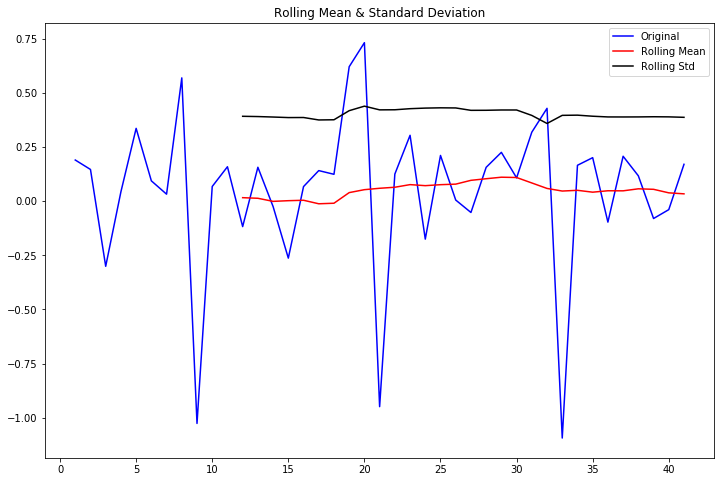

Test Statistic                -6.871667e+00
p-value                        1.510148e-09
#Lags Used                     1.000000e+00
Number of Observations Used    3.900000e+01
Critical Value (1%)           -3.610400e+00
Critical Value (5%)           -2.939109e+00
Critical Value (10%)          -2.608063e+00
dtype: float64


In [12]:
(df['log_diffR']).dropna(inplace=True)
test_stationarity(df['log_diffR'])

# Causality Test 

In [13]:
print(sm.tsa.stattools.grangercausalitytests(df[['log_diffR','diffH']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1607  , p=0.6908  , df_denom=37, df_num=1
ssr based chi2 test:   chi2=0.1738  , p=0.6768  , df=1
likelihood ratio test: chi2=0.1734  , p=0.6771  , df=1
parameter F test:         F=0.1607  , p=0.6908  , df_denom=37, df_num=1
{1: ({'ssr_ftest': (0.16074514890017297, 0.6907773976408094, 37.0, 1), 'ssr_chi2test': (0.17377853935153836, 0.6767753030930914, 1), 'lrtest': (0.17340214186198466, 0.6771057482679053, 1), 'params_ftest': (0.16074514890017677, 0.6907773976408094, 37.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f2e0697ddd8>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f2e06924e48>, array([[0., 1., 0.]])])}


In [14]:
print(sm.tsa.stattools.grangercausalitytests(df[['diffH','log_diffR']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1978  , p=0.0174  , df_denom=37, df_num=1
ssr based chi2 test:   chi2=6.7004  , p=0.0096  , df=1
likelihood ratio test: chi2=6.1949  , p=0.0128  , df=1
parameter F test:         F=6.1978  , p=0.0174  , df_denom=37, df_num=1
{1: ({'ssr_ftest': (6.197838886246335, 0.01741185831313547, 37.0, 1), 'ssr_chi2test': (6.700366363509552, 0.00963931027367414, 1), 'lrtest': (6.19490222292697, 0.012811880232105742, 1), 'params_ftest': (6.197838886246342, 0.017411858313135426, 37.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f2e0698ddd8>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f2e0697dd68>, array([[0., 1., 0.]])])}


# Correlation Check 

In [15]:
df['log_diffR'].corr(df['diffH'])

0.07846630821221663

In [16]:
#from scipy.stats.stats import pearsonr 
#pearsonr(df['log_Revenue'],df['Holidays'])

In [17]:
df=df.dropna()

In [18]:
df.head(5)

,Date,Revenue,Holidays,const,log_Revenue,log_diffR,diffH
1,05/2015,53937.649610,4,1,10.895584,0.190233,4
2,06/2015,62453.156104,2,1,11.042172,0.146588,2
3,07/2015,46229.681728,0,1,10.741377,-0.300795,0
4,08/2015,48286.857112,1,1,10.784915,0.043537,1
5,09/2015,67602.891624,1,1,11.121406,0.336491,1


In [19]:
#df['diffR']=df['Revenue'].diff(2)
model2=sm.OLS(endog= df['log_diffR'].dropna(),exog=df[['diffH','const']].dropna())
results2=model1.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                   0.05475
Date:                Thu, 21 Feb 2019   Prob (F-statistic):              0.816
Time:                        20:22:58   Log-Likelihood:                -546.63
No. Observations:                  42   AIC:                             1097.
Df Residuals:                      40   BIC:                             1101.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Holidays    3755.9565   1.61e+04      0.234      0.8

coefficient is the ratio of the trends not the effect that X has on Y.

Both the F-test and p-value from the “gc” variable (Granger Causality) are used for determining correlations.

In [20]:
# df['lag']=df['diffM'].shift()
# df.dropna(inplace=True)
# model3=sm.tsa.ARIMA(endog=df['Sales'],exog=df[['lag']],order=[1,1,0])
# results3=model3.fit()
# print(results3.summary())

In [21]:
import pyflux as pf
model = pf.ARIMAX(data = df, formula='log_diffR ~ 1+diffH',
                  ar=1,ma=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: log_diffR                           Method: MLE                                       
Start Date: 2                                           Log Likelihood: -5.2349                           
End Date: 41                                            AIC: 20.4698                                      
Number of observations: 40                              BIC: 28.9142                                      
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.3454     0.1205     2.866    0.0042   (0.1092 | 0.5816)        
MA(1)                                